<a href="https://colab.research.google.com/github/yzhou359/MakeItTalk/blob/main/quick_demo_tdlr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MakeItTalk Quick Demo (natural human face animation)

## TDLR version

Remember to change to GPU runtime first!

## Preparation (run only once)

In [ ]:
print('Git clone project and install requirements...')
!git clone https://github.com/yzhou359/MakeItTalk &> /dev/null
%cd MakeItTalk/
!export PYTHONPATH=/content/MakeItTalk:$PYTHONPATH
!pip install -r requirements.txt &> /dev/null
!pip install tensorboardX &> /dev/null
!mkdir examples/dump
!mkdir examples/ckpt
!pip install gdown &> /dev/null
print('Done!')
print('Download pre-trained models...')
!gdown -O examples/ckpt/ckpt_autovc.pth https://drive.google.com/uc?id=1ZiwPp_h62LtjU0DwpelLUoodKPR85K7x
!gdown -O examples/ckpt/ckpt_content_branch.pth https://drive.google.com/uc?id=1r3bfEvTVl6pCNw5xwUhEglwDHjWtAqQp
!gdown -O examples/ckpt/ckpt_speaker_branch.pth https://drive.google.com/uc?id=1rV0jkyDqPW-aDJcj7xSO6Zt1zSXqn1mu
!gdown -O examples/ckpt/ckpt_116_i2i_comb.pth https://drive.google.com/uc?id=1i2LJXKp-yWKIEEgJ7C6cE3_2NirfY_0a
!gdown -O examples/dump/emb.pickle https://drive.google.com/uc?id=18-0CYl5E6ungS3H4rRSHjfYvvm-WwjTI
print('Done!')

Git clone project and install requirements...
/content/MakeItTalk
Done!
Download pre-trained models...
Downloading...
From: https://drive.google.com/uc?id=1ZiwPp_h62LtjU0DwpelLUoodKPR85K7x
To: /content/MakeItTalk/examples/ckpt/ckpt_autovc.pth
172MB [00:02, 64.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1r3bfEvTVl6pCNw5xwUhEglwDHjWtAqQp
To: /content/MakeItTalk/examples/ckpt/ckpt_content_branch.pth
7.88MB [00:00, 69.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rV0jkyDqPW-aDJcj7xSO6Zt1zSXqn1mu
To: /content/MakeItTalk/examples/ckpt/ckpt_speaker_branch.pth
15.4MB [00:00, 71.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i2LJXKp-yWKIEEgJ7C6cE3_2NirfY_0a
To: /content/MakeItTalk/examples/ckpt/ckpt_116_i2i_comb.pth
839MB [00:06, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=18-0CYl5E6ungS3H4rRSHjfYvvm-WwjTI
To: /content/MakeItTalk/examples/dump/emb.pickle
30.9MB [00:00, 84.8MB/s]
Done!


## Animate your photos here!

- Upload your images to `examples` with size `256x256`. Or use existing ones.

- Upload your speech audio files (could be many) to `examples`. Since it will process all `.wav` files under `examples`, remember to delete non-necessary `.wav` files. Or use an existing one `M6_04_16k.wav`.

## Step 1/3: Choose your image (in below Dropdown). 

Choose the image name to animate: (saved in folder 'examples/')


Dropdown(index=41, options=('angelina', 'anne', 'anne2', 'audrey', 'aya', 'captain', 'captain2', 'cesi', 'chri…

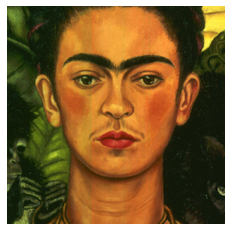

In [1]:
import ipywidgets as widgets
import glob
import matplotlib.pyplot as plt
print("Choose the image name to animate: (saved in folder 'examples/')")
img_list = glob.glob1('examples', '*.jpg')
img_list.sort()
img_list = [item.split('.')[0] for item in img_list]
default_head_name = widgets.Dropdown(options=img_list, value='paint_boy')
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        plt.imshow(plt.imread('examples/{}.jpg'.format(default_head_name.value)))
        plt.axis('off')
        plt.show()
default_head_name.observe(on_change)
display(default_head_name)
plt.imshow(plt.imread('examples/{}.jpg'.format(default_head_name.value)))
plt.axis('off')
plt.show()

## Step 2/3: Setup your animation controllers (on right Sliders).

In [2]:
#@markdown # Animation Controllers
#@markdown Amplify the lip motion in horizontal direction
AMP_LIP_SHAPE_X = 2 #@param {type:"slider", min:0.5, max:5.0, step:0.1}

#@markdown Amplify the lip motion in vertical direction
AMP_LIP_SHAPE_Y = 2 #@param {type:"slider", min:0.5, max:5.0, step:0.1}

#@markdown Amplify the head pose motion (usually smaller than 1.0, put it to 0. for a static head pose)
AMP_HEAD_POSE_MOTION = 0.35 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

#@markdown Add naive eye blink
ADD_NAIVE_EYE = True  #@param ["False", "True"] {type:"raw"}

#@markdown If your image has an opened mouth, put this as True, else False
CLOSE_INPUT_FACE_MOUTH = False  #@param ["False", "True"] {type:"raw"}          


#@markdown # Landmark Adjustment

#@markdown Adjust upper lip thickness (postive value means thicker)
UPPER_LIP_ADJUST = -1 #@param {type:"slider", min:-3.0, max:3.0, step:1.0}

#@markdown Adjust lower lip thickness (postive value means thicker)
LOWER_LIP_ADJUST = -1 #@param {type:"slider", min:-3.0, max:3.0, step:1.0}

#@markdown Adjust static lip width (in multipication)
LIP_WIDTH_ADJUST = 1.0 #@param {type:"slider", min:0.8, max:1.2, step:0.01}

## Step 3/3: One-click to Run (just wait in seconds).

In [3]:
import sys
sys.path.append("thirdparty/AdaptiveWingLoss")
import os, glob
import numpy as np
import cv2
import argparse
from src.approaches.train_image_translation import Image_translation_block
import torch
import pickle
import face_alignment
from src.autovc.AutoVC_mel_Convertor_retrain_version import AutoVC_mel_Convertor
import shutil
import time
import util.utils as util
from scipy.signal import savgol_filter
from src.approaches.train_audio2landmark import Audio2landmark_model

sys.stdout = open(os.devnull, 'a')

parser = argparse.ArgumentParser()
parser.add_argument('--jpg', type=str, default='{}.jpg'.format(default_head_name.value))
parser.add_argument('--close_input_face_mouth', default=CLOSE_INPUT_FACE_MOUTH, action='store_true')
parser.add_argument('--load_AUTOVC_name', type=str, default='examples/ckpt/ckpt_autovc.pth')
parser.add_argument('--load_a2l_G_name', type=str, default='examples/ckpt/ckpt_speaker_branch.pth')
parser.add_argument('--load_a2l_C_name', type=str, default='examples/ckpt/ckpt_content_branch.pth') #ckpt_audio2landmark_c.pth')
parser.add_argument('--load_G_name', type=str, default='examples/ckpt/ckpt_116_i2i_comb.pth') #ckpt_image2image.pth') #ckpt_i2i_finetune_150.pth') #c
parser.add_argument('--amp_lip_x', type=float, default=AMP_LIP_SHAPE_X)
parser.add_argument('--amp_lip_y', type=float, default=AMP_LIP_SHAPE_Y)
parser.add_argument('--amp_pos', type=float, default=AMP_HEAD_POSE_MOTION)
parser.add_argument('--reuse_train_emb_list', type=str, nargs='+', default=[]) #  ['iWeklsXc0H8']) #['45hn7-LXDX8']) #['E_kmpT-EfOg']) #'iWeklsXc0H8', '29k8RtSUjE0', '45hn7-LXDX8',
parser.add_argument('--add_audio_in', default=False, action='store_true')
parser.add_argument('--comb_fan_awing', default=False, action='store_true')
parser.add_argument('--output_folder', type=str, default='examples')
parser.add_argument('--test_end2end', default=True, action='store_true')
parser.add_argument('--dump_dir', type=str, default='', help='')
parser.add_argument('--pos_dim', default=7, type=int)
parser.add_argument('--use_prior_net', default=True, action='store_true')
parser.add_argument('--transformer_d_model', default=32, type=int)
parser.add_argument('--transformer_N', default=2, type=int)
parser.add_argument('--transformer_heads', default=2, type=int)
parser.add_argument('--spk_emb_enc_size', default=16, type=int)
parser.add_argument('--init_content_encoder', type=str, default='')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--reg_lr', type=float, default=1e-6, help='weight decay')
parser.add_argument('--write', default=False, action='store_true')
parser.add_argument('--segment_batch_size', type=int, default=1, help='batch size')
parser.add_argument('--emb_coef', default=3.0, type=float)
parser.add_argument('--lambda_laplacian_smooth_loss', default=1.0, type=float)
parser.add_argument('--use_11spk_only', default=False, action='store_true')
parser.add_argument('-f')
opt_parser = parser.parse_args()

img = cv2.imread('examples/' + opt_parser.jpg)
predictor = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cpu', flip_input=True)
shapes = predictor.get_landmarks(img)
if (not shapes or len(shapes) != 1):
    print('Cannot detect face landmarks. Exit.')
    exit(-1)
shape_3d = shapes[0]
if(opt_parser.close_input_face_mouth):
    util.close_input_face_mouth(shape_3d)
shape_3d[48:, 0] = (shape_3d[48:, 0] - np.mean(shape_3d[48:, 0])) * LIP_WIDTH_ADJUST + np.mean(shape_3d[48:, 0]) # wider lips
shape_3d[49:54, 1] -= UPPER_LIP_ADJUST           # thinner upper lip
shape_3d[55:60, 1] += LOWER_LIP_ADJUST           # thinner lower lip
shape_3d[[37,38,43,44], 1] -=2.    # larger eyes
shape_3d[[40,41,46,47], 1] +=2.    # larger eyes
shape_3d, scale, shift = util.norm_input_face(shape_3d)

print("Loaded Image...", file=sys.stderr)

au_data = []
au_emb = []
ains = glob.glob1('examples', '*.wav')
ains = [item for item in ains if item is not 'tmp.wav']
ains.sort()
for ain in ains:
    os.system('ffmpeg -y -loglevel error -i examples/{} -ar 16000 examples/tmp.wav'.format(ain))
    shutil.copyfile('examples/tmp.wav', 'examples/{}'.format(ain))

    # au embedding
    from thirdparty.resemblyer_util.speaker_emb import get_spk_emb
    me, ae = get_spk_emb('examples/{}'.format(ain))
    au_emb.append(me.reshape(-1))

    print('Processing audio file', ain)
    c = AutoVC_mel_Convertor('examples')

    au_data_i = c.convert_single_wav_to_autovc_input(audio_filename=os.path.join('examples', ain),
           autovc_model_path=opt_parser.load_AUTOVC_name)
    au_data += au_data_i
if(os.path.isfile('examples/tmp.wav')):
    os.remove('examples/tmp.wav')

print("Loaded audio...", file=sys.stderr)

# landmark fake placeholder
fl_data = []
rot_tran, rot_quat, anchor_t_shape = [], [], []
for au, info in au_data:
    au_length = au.shape[0]
    fl = np.zeros(shape=(au_length, 68 * 3))
    fl_data.append((fl, info))
    rot_tran.append(np.zeros(shape=(au_length, 3, 4)))
    rot_quat.append(np.zeros(shape=(au_length, 4)))
    anchor_t_shape.append(np.zeros(shape=(au_length, 68 * 3)))

if(os.path.exists(os.path.join('examples', 'dump', 'random_val_fl.pickle'))):
    os.remove(os.path.join('examples', 'dump', 'random_val_fl.pickle'))
if(os.path.exists(os.path.join('examples', 'dump', 'random_val_fl_interp.pickle'))):
    os.remove(os.path.join('examples', 'dump', 'random_val_fl_interp.pickle'))
if(os.path.exists(os.path.join('examples', 'dump', 'random_val_au.pickle'))):
    os.remove(os.path.join('examples', 'dump', 'random_val_au.pickle'))
if (os.path.exists(os.path.join('examples', 'dump', 'random_val_gaze.pickle'))):
    os.remove(os.path.join('examples', 'dump', 'random_val_gaze.pickle'))

with open(os.path.join('examples', 'dump', 'random_val_fl.pickle'), 'wb') as fp:
    pickle.dump(fl_data, fp)
with open(os.path.join('examples', 'dump', 'random_val_au.pickle'), 'wb') as fp:
    pickle.dump(au_data, fp)
with open(os.path.join('examples', 'dump', 'random_val_gaze.pickle'), 'wb') as fp:
    gaze = {'rot_trans':rot_tran, 'rot_quat':rot_quat, 'anchor_t_shape':anchor_t_shape}
    pickle.dump(gaze, fp)

model = Audio2landmark_model(opt_parser, jpg_shape=shape_3d)
if(len(opt_parser.reuse_train_emb_list) == 0):
    model.test(au_emb=au_emb)
else:
    model.test(au_emb=None)

print("Audio->Landmark...", file=sys.stderr)

fls = glob.glob1('examples', 'pred_fls_*.txt')
fls.sort()

for i in range(0,len(fls)):
    fl = np.loadtxt(os.path.join('examples', fls[i])).reshape((-1, 68,3))
    fl[:, :, 0:2] = -fl[:, :, 0:2]
    fl[:, :, 0:2] = fl[:, :, 0:2] / scale - shift

    if (ADD_NAIVE_EYE):
        fl = util.add_naive_eye(fl)

    # additional smooth
    fl = fl.reshape((-1, 204))
    fl[:, :48 * 3] = savgol_filter(fl[:, :48 * 3], 15, 3, axis=0)
    fl[:, 48*3:] = savgol_filter(fl[:, 48*3:], 5, 3, axis=0)
    fl = fl.reshape((-1, 68, 3))

    ''' STEP 6: Imag2image translation '''
    model = Image_translation_block(opt_parser, single_test=True)
    with torch.no_grad():
        model.single_test(jpg=img, fls=fl, filename=fls[i], prefix=opt_parser.jpg.split('.')[0])
        print('finish image2image gen')
    os.remove(os.path.join('examples', fls[i]))

    print("{} / {}: Landmark->Face...".format(i+1, len(fls)), file=sys.stderr)
print("Done!", file=sys.stderr)

<>:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
Loaded Image...
<ipython-input-3-fc3b009acf6e>:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  ains = [item for item in ains if item is not 'tmp.wav']
Loaded audio...
/home/faizan/cvit/MakeItTalk/src/approaches/train_audio2landmark.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(torch.zeros(aus.shape[0], 128), requires_grad=False, dtype=torch.float).to(device)
Audio->Landmark...
1 / 1: Landmark->Face...
Done!


## Visualize your animation!

In [4]:
from IPython.display import HTML
from base64 import b64encode

for ain in ains:
  OUTPUT_MP4_NAME = '{}_pred_fls_{}_audio_embed.mp4'.format(
    opt_parser.jpg.split('.')[0],
    ain.split('.')[0]
    )
  mp4 = open('examples/{}'.format(OUTPUT_MP4_NAME),'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  print('Display animation: examples/{}'.format(OUTPUT_MP4_NAME), file=sys.stderr)
  display(HTML("""
  <video width=600 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url))

Display animation: examples/paint_boy_pred_fls_M6_04_16k_audio_embed.mp4
